In [2]:
import geopandas as gpd
from pathlib import Path
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

## Select the reservoir

In [3]:
RESERVOIR = 3

In [4]:
# read the bounding box of the study area
RESERVOIRS_GDF = gpd.read_file(Path('/tiger1/pdas47/resorr-swot/data/cumberland-reservoirs/03-cumberland-reservoirs.geojson'))

res_names = RESERVOIRS_GDF[['id', 'name']].set_index('id').to_dict()['name'] # dictionary that can be queried to get reservoir name

RESERVOIR_NAME = res_names[RESERVOIR]

RESERVOIR_GDF = RESERVOIRS_GDF.loc[RESERVOIRS_GDF['id'] == RESERVOIR]

# get reservoir properties from GRanD
nominal_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_SKM'].values[0]
nominal_area_poly = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_POLY'].values[0]
max_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_MAX'].values[0]
max_area = np.nan if max_area == -99 else max_area

min_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_MIN'].values[0]
min_area = 0 if min_area == -99 else min_area

area_rep = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_REP'].values[0]
dam_height = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['DAM_HGT_M'].values[0])
elev_msl = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['ELEV_MASL'].values[0])
depth = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['DEPTH_M'].values[0])
capacity = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['CAP_MCM'].values[0])

print(RESERVOIR_NAME)

Dale_Hollow_Dam


Text(0.5, 1.0, 'Capacity of Dale Hollow Dam')

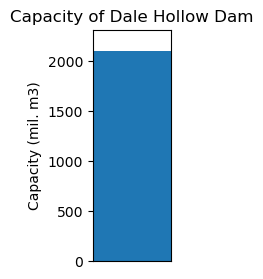

In [5]:
# what is the reported capacity?
f, ax = plt.subplots(figsize=(1,3))

ax.axhspan(0, capacity)
ax.set_ylim(0, capacity*1.1)
ax.set_xticks([])
ax.set_ylabel('Capacity (mil. m3)')
ax.set_title(f'Capacity of {RESERVOIR_NAME.replace("_", " ")}')

In [6]:
def get_insitu_observed_data(
        id, 
        RESERVOIRS_GDF, 
        src_dir = Path('/tiger1/pdas47/resorr-swot/data/insitu/resops')
    ):
    row = RESERVOIRS_GDF[RESERVOIRS_GDF['id'] == id]
    name = row['name'].values[0]
    src_dir = Path(src_dir)
    src = src_dir.name

    if src == 'resops':
        src_fn = src_dir / f'{name}.csv'
        insitu_df = pd.read_csv(src_fn)
    elif src =='usace':
        name_without_dam = name.replace('_Dam', '')
        elevation_src_fn = src_dir / f'{name_without_dam}-elevation'
        inflow_src_fn = src_dir / f'{name_without_dam}-inflow'
        outflow_src_fn = src_dir / f'{name_without_dam}-outflow'
        storage_src_fn = src_dir / f'{name_without_dam}-storage'

        elevation_df = pd.read_csv(elevation_src_fn, comment='#', names=['time', 'elevation'], index_col=0)
        elevation_df.index = pd.to_datetime(elevation_df.index)
        inflow_df = pd.read_csv(inflow_src_fn, comment='#', names=['time', 'inflow'], index_col=0)
        inflow_df.index = pd.to_datetime(inflow_df.index)
        outflow_df = pd.read_csv(outflow_src_fn, comment='#', names=['time', 'outflow'], index_col=0)
        outflow_df.index = pd.to_datetime(outflow_df.index)
        storage_df = pd.read_csv(storage_src_fn, comment='#', names=['time', 'storage'], index_col=0)
        storage_df.index = pd.to_datetime(storage_df.index)

        insitu_df = pd.concat([elevation_df, inflow_df, outflow_df, storage_df], axis=1)
        # insitu data is in hourly time format
        insitu_df = insitu_df.resample('1D').median()
        # convert from imperial to SI
        insitu_df['elevation'] = insitu_df['elevation'] * 0.3048
        insitu_df['inflow'] = insitu_df['inflow'] * 0.028316847
        insitu_df['outflow'] = insitu_df['outflow'] * 0.028316847
        insitu_df['storage'] = insitu_df['storage'] * 1233.48


    return insitu_df


observed_df = get_insitu_observed_data(RESERVOIR, RESERVOIRS_GDF, '/tiger1/pdas47/resorr-swot/data/insitu/usace')
observed_df

,elevation,inflow,outflow,storage
time,,,,
2019-01-01 00:00:00+00:00,198.415,464.170007,NaN,1.668467e+09
2019-01-02 00:00:00+00:00,198.580,90.190001,NaN,1.687131e+09
2019-01-03 00:00:00+00:00,198.650,177.970003,NaN,1.694701e+09
2019-01-04 00:00:00+00:00,198.680,176.270003,NaN,1.698496e+09
2019-01-05 00:00:00+00:00,198.780,224.640003,NaN,1.709189e+09
...,...,...,...,...
2025-06-17 00:00:00+00:00,198.240,50.120001,0.710000,1.648721e+09
2025-06-18 00:00:00+00:00,198.345,98.770001,2.120000,1.660114e+09
2025-06-19 00:00:00+00:00,198.420,123.320002,50.550001,1.668638e+09


In [7]:
observed_df = observed_df[observed_df['storage'] > 0]

<Axes: xlabel='storage', ylabel='elevation'>

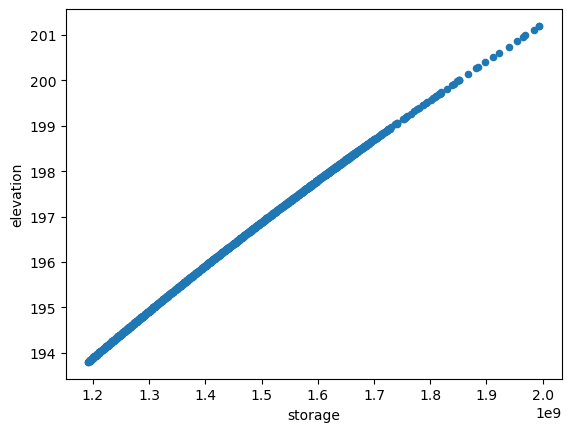

In [8]:
f, ax = plt.subplots()

observed_df.plot(
    ax=ax,
    kind='scatter',
    x='storage',
    y='elevation'
)

Text(0, 0.5, 'Storage $mil. m^3$')

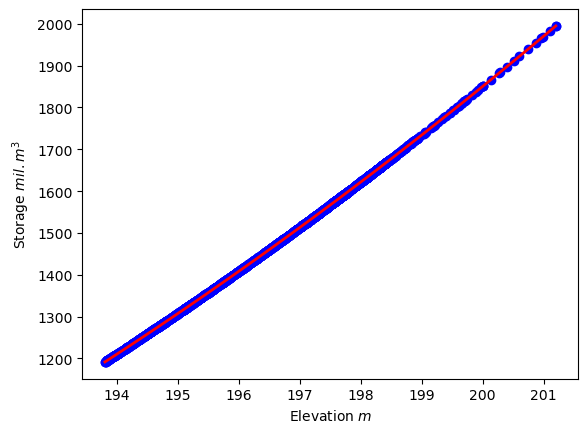

In [ ]:
# Fit a 2-degree polynomial
coefficients = np.polyfit(observed_df['elevation'], observed_df['storage'], 2)
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the polynomial
x_values = np.linspace(observed_df['elevation'].min(), observed_df['elevation'].max(), 100)
y_values = polynomial(x_values)


f, ax = plt.subplots()
ax.scatter(
    x = observed_df['elevation'],
    y = observed_df['storage'] * 1e-6,
    color = 'blue'
)
ax.add_line(
    plt.Line2D(
        xdata = x_values,
        ydata = y_values * 1e-6,
        color='red',
        lw=2
    )
)
ax.set_xlabel('Elevation $m$')
ax.set_ylabel('Storage $mil. m^3$')
# # Plot the observed data and the polynomial fit
# plot = observed_df.hvplot.scatter(
#     x='observed wse [m]', y='observed storage [Mm3]', color='blue', title=f'Observed storage and water surface elevation for {RESERVOIR_NAME}'
# ).opts(width=700, height=500) * hv.Curve((x_values, y_values), label='2-degree polynomial fit').opts(color='red')
# plot

In [10]:
# Fit polynomial curves to predict storage from elevation and area
coefficients_elevation = np.polyfit(observed_df['elevation'], observed_df['storage'], 2)
polynomial_elevation = np.poly1d(coefficients_elevation)

# Generate equally spaced elevation values
min_elevation = np.floor(observed_df['elevation'].min() / 0.25) * 0.25
max_elevation = np.ceil(observed_df['elevation'].max() / 0.25) * 0.25
elevation_values = np.arange(min_elevation, max_elevation + 0.25, 0.25)

# Predict storage values using the polynomial functions
predicted_storage_elevation = polynomial_elevation(elevation_values)

# Interpolate the observed storage using linear interpolation for the elevation_values
observed_storage_interpolated = np.interp(elevation_values, observed_df['elevation'], observed_df['storage'])

# Create a dataframe with the predicted storage, interpolated observed storage, and elevation values
predicted_df = pd.DataFrame({
    'Elevation': elevation_values,
    'Storage (mil. m3)': predicted_storage_elevation,
})

# Save the polynomial functions as comments
polynomial_elevation_str = f"Polynomial function (Elevation): {polynomial_elevation}"

# Display the dataframe and polynomial functions
print(polynomial_elevation_str)
predicted_df

Polynomial function (Elevation):            2
1.911e+06 x - 6.462e+08 x + 5.466e+10


,Elevation,Storage (mil. m3)
0,193.75,1.187078e+09
1,194.00,1.210750e+09
2,194.25,1.234662e+09
3,194.50,1.258812e+09
4,194.75,1.283201e+09
5,195.00,1.307829e+09
6,195.25,1.332696e+09
7,195.50,1.357801e+09
8,195.75,1.383146e+09
9,196.00,1.408729e+09


In [11]:
# output_dir = Path('/tiger1/pdas47/resorr-swot/data/aec/insitu_aev')
# output_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

# output_file = output_dir / f'{RESERVOIR}.csv'
# predicted_df.to_csv(output_file, index=False)

## Adding Area to AEV.

Methodology:
1. Create a relationship between min-max Area and min-max Elevation (in-situ observed).
2. Create a polynomial function to convert between the two. Then generate Area-Storage curves.

In [12]:
observed_df

,elevation,inflow,outflow,storage
time,,,,
2019-01-01 00:00:00+00:00,198.415,464.170007,NaN,1.668467e+09
2019-01-02 00:00:00+00:00,198.580,90.190001,NaN,1.687131e+09
2019-01-03 00:00:00+00:00,198.650,177.970003,NaN,1.694701e+09
2019-01-04 00:00:00+00:00,198.680,176.270003,NaN,1.698496e+09
2019-01-05 00:00:00+00:00,198.780,224.640003,NaN,1.709189e+09
...,...,...,...,...
2025-06-17 00:00:00+00:00,198.240,50.120001,0.710000,1.648721e+09
2025-06-18 00:00:00+00:00,198.345,98.770001,2.120000,1.660114e+09
2025-06-19 00:00:00+00:00,198.420,123.320002,50.550001,1.668638e+09


In [13]:
import difflib

inp_dir = Path('/tiger1/pdas47/resorr-swot/data/USA/basins/cumberland/gee/gee_sarea_tmsos')

files = inp_dir.glob("*.csv")
scores = []
for fp in files:
    stem = fp.stem
    # remove leading numeric ID if present (e.g. "1752.0_Barkley_Dam" -> "Barkley_Dam")
    parts = stem.split('_')
    if parts and any(ch.isdigit() for ch in parts[0]):
        cleaned = '_'.join(parts[1:]) or stem
    else:
        cleaned = stem

    r1 = difflib.SequenceMatcher(None, RESERVOIR_NAME.lower(), stem.lower()).ratio()
    r2 = difflib.SequenceMatcher(None, RESERVOIR_NAME.lower(), cleaned.lower()).ratio()
    score = max(r1, r2)
    scores.append((fp, stem, cleaned, score))

best_fp, best_stem, best_clean, best_score = max(scores, key=lambda x: x[3])
selected = best_fp
print(f"selected: {selected} (score={best_score:.3f}, stem='{best_stem}', cleaned='{best_clean}')")
fp = best_fp

sat_df = pd.read_csv(fp, parse_dates=['date'])

sat_df

selected: /tiger1/pdas47/resorr-swot/data/USA/basins/cumberland/gee/gee_sarea_tmsos/1762.0_Dale_Hollow_Dam.csv (score=1.000, stem='1762.0_Dale_Hollow_Dam', cleaned='Dale_Hollow_Dam')


,date,water_area_uncorrected,non_water_area,cloud_area,unfiltered_area,cloud_percent,QUALITY_DESCRIPTION,sat,filtered_area,corrected_areas_1,corrected_trend_1,sar_trend,days_passed,area
0,2022-06-11,0.000000,0.000000,282.482677,101.763756,100.000000,0.0,s2,101.763756,102.517029,0.150655,-0.008443,5.0,102.517029
1,2022-06-16,96.748863,193.889020,25.615143,102.517029,8.099573,0.0,s2,102.517029,102.517029,0.150655,-0.021108,5.0,102.517029
2,2022-06-18,73.076593,183.467135,59.703527,98.570007,18.878750,0.0,l8,98.570007,98.570007,-1.973511,-0.021108,2.0,98.570007
3,2022-06-21,102.886234,213.441922,-0.075130,102.886234,-0.023756,0.0,s2,102.886234,102.886234,1.438742,-0.021108,3.0,102.886234
4,2022-06-26,81.923273,198.396413,35.601580,NaN,11.269131,0.0,l9,NaN,NaN,NaN,-0.067067,5.0,102.550897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2025-10-08,0.000000,0.000000,282.482677,98.275704,100.000000,0.0,s2,98.275704,98.275704,0.000000,0.329418,5.0,98.275704
364,2025-10-13,0.000000,0.000000,282.482677,98.275704,100.000000,0.0,s2,98.275704,98.275704,0.000000,0.329418,5.0,98.275704
365,2025-10-18,0.000000,0.000000,282.482677,98.275704,100.000000,0.0,s2,98.275704,98.275704,0.000000,0.131767,5.0,98.275704
366,2025-10-23,0.000000,0.000000,282.482677,98.275704,100.000000,0.0,s2,98.275704,98.275704,0.000000,NaN,5.0,98.275704


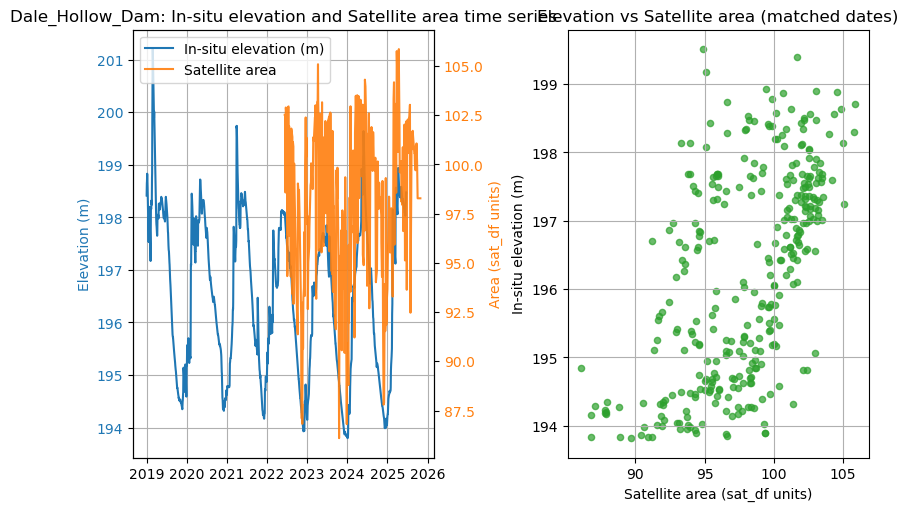

In [14]:
# plot time series (elevation from in-situ) and satellite area, plus scatter of area vs elevation
# uses existing variables: observed_df, sat_df, RESERVOIR_NAME

# prepare in-situ elevation series (make tz-naive if necessary)
obs = observed_df.copy()
if getattr(obs.index, 'tz', None) is not None:
    obs_index = obs.index.tz_convert(None)
else:
    obs_index = obs.index
obs_elev = pd.Series(obs['elevation'].values, index=obs_index, name='elevation')

# prepare satellite area series (ensure datetime)
sat = sat_df.copy()
sat['date'] = pd.to_datetime(sat['date'])
sat_area = sat.set_index('date')['area'].rename('area')

# create figure with two subplots (time series with twin y, and scatter)
fig, axes = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)

# time series: elevation (left y) and area (right y)
ax1 = axes[0]
ax1.plot(obs_elev.index, obs_elev.values, color='tab:blue', label='In-situ elevation (m)')
ax1.set_ylabel('Elevation (m)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax1_twin = ax1.twinx()
ax1_twin.plot(sat_area.index, sat_area.values, color='tab:orange', alpha=0.9, label='Satellite area')
ax1_twin.set_ylabel('Area (sat_df units)', color='tab:orange')
ax1_twin.tick_params(axis='y', labelcolor='tab:orange')

ax1.set_title(f'{RESERVOIR_NAME}: In-situ elevation and Satellite area time series')
ax1.grid(True)
# combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# scatter: area vs elevation (match by date)
combined = pd.concat([obs_elev, sat_area], axis=1).dropna()
ax2 = axes[1]
ax2.scatter(combined['area'], combined['elevation'], s=20, alpha=0.7, color='tab:green')
ax2.set_xlabel('Satellite area (sat_df units)')
ax2.set_ylabel('In-situ elevation (m)')
ax2.set_title('Elevation vs Satellite area (matched dates)')
ax2.grid(True)

plt.show()

In [15]:
import holoviews as hv
import panel as pn

pn.extension('bokeh')

# Build combined_sorted by matching in-situ elevation and satellite area on dates
obs = observed_df.copy()
if getattr(obs.index, 'tz', None) is not None:
    obs_index = obs.index.tz_convert(None)
else:
    obs_index = obs.index
obs_elev = pd.Series(obs['elevation'].values, index=obs_index, name='elevation')

sat = sat_df.copy()
sat['date'] = pd.to_datetime(sat['date'])
sat_area = sat.set_index('date')['area'].rename('area')

# align, drop unmatched, and sort
combined_sorted = pd.concat([obs_elev, sat_area], axis=1).dropna().sort_index()

# compute day-to-day deltas (can be negative)
deltas = combined_sorted.diff().dropna()

# Ensure datetime index is tz-naive and ready for holoviews
combined_sorted = combined_sorted.copy()
combined_sorted.index = pd.to_datetime(combined_sorted.index)

deltas = deltas.copy()
deltas.index = pd.to_datetime(deltas.index)

# Prepare dataframes for holoviews (reset index so date is a column)
df = combined_sorted.reset_index().rename(columns={'index': 'date'})
deltas_df = deltas.reset_index().rename(columns={'index': 'date'})

df = df.merge(
    deltas_df.rename(columns={'elevation': 'delta_elevation', 'area': 'delta_area'}),
    on='date',
    how='left'
)
dataset = hv.Dataset(df)

# ---- Plot Definitions ----

elev_points = hv.Points(dataset, ['date', 'elevation']).opts(
    color='blue', size=5,
    nonselection_alpha=0.1,
    selection_color='red',
    tools=['hover', 'box_select', 'lasso_select'],
    active_tools=['lasso_select']
)

area_points = hv.Points(dataset, ['date', 'area']).opts(
    color='orange', size=5,
    nonselection_alpha=0.1,
    selection_color='red',
    tools=['hover', 'box_select', 'lasso_select'],
    active_tools=['lasso_select']
)

scatter = hv.Points(dataset, ['area', 'elevation']).opts(
    color='green', size=6,
    nonselection_alpha=0.1,
    selection_color='red',
    tools=['hover', 'box_select', 'lasso_select'],
    active_tools=['lasso_select']
)
# Delta scatter with selection tools
delta_points = hv.Points(dataset, ['delta_area', 'delta_elevation']).opts(
    color='purple', size=6,
    nonselection_alpha=0.1,
    selection_color='red',
    tools=['hover', 'box_select', 'lasso_select'],
    active_tools=['lasso_select']
)

# Combine everything into a flat Layout using +
hv_layout = (elev_points + area_points + scatter + delta_points).cols(4)

# Link selections
link = hv.link_selections.instance()
linked = link(hv_layout).opts(shared_axes=False)

# Wrap in Panel layout (optional)
panel_layout = pn.Row(linked)

panel_layout

BokehModel(combine_events=True, render_bundle={'docs_json': {'bc19b34a-35fa-49bb-aeba-41ad71639c8c': {'version…

In [30]:
# fit a polynomial function to area-elevation data points. Constrain to a monotonically increasing polynomial
from polyfit import PolynomRegressor, Constraints

DEG = 2
X = df['elevation'].values.reshape([-1, 1])
y = df['area'].values
x_values = np.linspace(df['elevation'].min(), df['elevation'].max(), 100)

polyestimator = PolynomRegressor(deg=DEG)
monotone_constraint = Constraints(monotonicity='inc')
polyestimator.fit(X, y, loss = 'l2', constraints={0: monotone_constraint})
pred_mon = polyestimator.predict(x_values.reshape(-1, 1))

# do it using numpy for comparison
np_coefficients = np.polyfit(df['elevation'], df['area'], 2)
np_polynomial = np.poly1d(np_coefficients)
# Generate x values for plotting the polynomial
np_y_values = np_polynomial(x_values)

# f, ax = plt.subplots()
# ax.scatter(
#     x = df['elevation'],
#     y = df['area'],
#     color = 'blue'
# )
# ax.add_line(
#     plt.Line2D(
#         xdata = x_values,
#         ydata = y_values,
#         color='red',
#         lw=2
#     )
# )
# ax.set_xlabel('Elevation $m$')
# ax.set_ylabel('Area km^2$')

Text(0, 0.5, 'Area $km^2$')

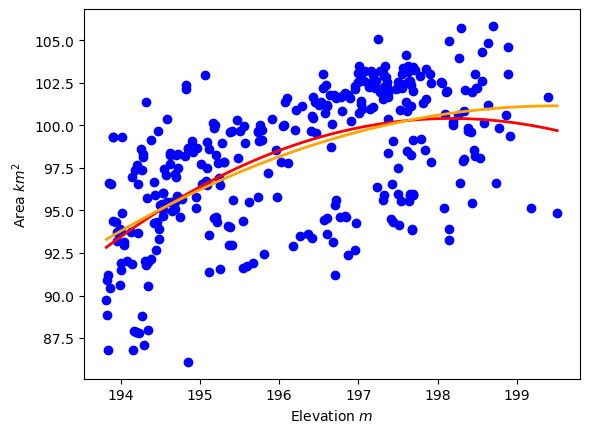

In [31]:
# fit a polynomial function to area-elevation data points. Constrain to a monotonically increasing polynomial
from polyfit import PolynomRegressor, Constraints

DEG = 2
X = df['elevation'].values.reshape([-1, 1])
y = df['area'].values
x_values = np.linspace(df['elevation'].min(), df['elevation'].max(), 100)

polyestimator = PolynomRegressor(deg=DEG)
monotone_constraint = Constraints(monotonicity='inc')
polyestimator.fit(X, y, loss = 'l2', constraints={0: monotone_constraint})
pred_mon = polyestimator.predict(x_values.reshape(-1, 1))

# do it using numpy for comparison
np_coefficients = np.polyfit(df['elevation'], df['area'], 2)
np_polynomial = np.poly1d(np_coefficients)
# Generate x values for plotting the polynomial
np_y_values = np_polynomial(x_values)

f, ax = plt.subplots()
ax.scatter(
    x = df['elevation'],
    y = df['area'],
    color = 'blue'
)
ax.add_line(
    plt.Line2D(
        xdata = x_values,
        ydata = np_y_values,
        color='red',
        lw=2
    )
)
ax.add_line(
    plt.Line2D(
        xdata = x_values,
        ydata = pred_mon,
        color='orange',
        lw=2
    )
)
ax.set_xlabel('Elevation $m$')
ax.set_ylabel('Area $km^2$')

In [28]:
# insert area in the area-elevation curve
aev_area = polyestimator.predict(predicted_df['Elevation'].values.reshape(-1, 1))
predicted_df['Area'] = aev_area
predicted_df

,Elevation,Storage (mil. m3),Area
0,193.75,1.187078e+09,93.104044
1,194.00,1.210750e+09,93.787724
2,194.25,1.234662e+09,94.441072
3,194.50,1.258812e+09,95.064087
4,194.75,1.283201e+09,95.656771
5,195.00,1.307829e+09,96.219124
6,195.25,1.332696e+09,96.751144
7,195.50,1.357801e+09,97.252832
8,195.75,1.383146e+09,97.724189
9,196.00,1.408729e+09,98.165214


In [29]:
output_dir = Path('/tiger1/pdas47/resorr-swot/data/aec/area_augmented_insitu_aev')
output_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

output_file = output_dir / f'{RESERVOIR}.csv'
predicted_df.to_csv(output_file, index=False)

# how do they comapre to satellite derived AEV?

In [67]:
# from pathlib import Path
# import pandas as pd
# import numpy as np


In [68]:
# sat_aev = Path("/tiger1/pdas47/tmsosPP/data/aec/aev_extrapolated")
# insitu_aev = Path("/tiger1/pdas47/tmsosPP/data/aec/aev_insitu")

# sat_aev_files = list(sat_aev.glob('*.csv'))
# insitu_aev_files = list(insitu_aev.glob('*.csv'))
# sat_aev_names = [f.stem for f in sat_aev_files]
# insitu_aev_names = [f.stem for f in insitu_aev_files]

# common_aev_names = set(sat_aev_names).intersection(insitu_aev_names)

# print(len(common_aev_names))
# import HydroErr as he

# metrics = [
#     'ME', 'MAE', 'rmse', 'NRMSE range', 
#     'R^2', 'Pearson r', 'NSE', 'KGE 2012'
# ]

# metrics_fn = [
#     he.me, he.mae, he.rmse, he.nrmse_range, he.r_squared, he.pearson_r, he.nse, he.kge_2012, 
# ]

# metric_values = []

# for aev in common_aev_names:
#     sat_aev_fp = sat_aev / f'{aev}.csv'
#     insitu_aev_fp = insitu_aev / f'{aev}.csv'
#     sat_aev_df = pd.read_csv(sat_aev_fp, comment='#')
#     insitu_aev_df = pd.read_csv(insitu_aev_fp, comment='#')

#     if 'Storage (mil. m3)' not in sat_aev_df.columns:
#         continue

#     min_storage = max(sat_aev_df['Storage (mil. m3)'].min(), insitu_aev_df['Storage (mil. m3)'].min())
#     max_storage = min(sat_aev_df['Storage (mil. m3)'].max(), insitu_aev_df['Storage (mil. m3)'].max())

#     sat_aev_df = sat_aev_df[(sat_aev_df['Storage (mil. m3)'] >= min_storage) & (sat_aev_df['Storage (mil. m3)'] <= max_storage)]
#     insitu_aev_df = insitu_aev_df[(insitu_aev_df['Storage (mil. m3)'] >= min_storage) & (insitu_aev_df['Storage (mil. m3)'] <= max_storage)]

#     sat_elevation = sat_aev_df['Elevation'].values
#     insitu_elevation = insitu_aev_df['Elevation'].values
#     sat_storage = sat_aev_df['Storage (mil. m3)'].values
#     insitu_storage = insitu_aev_df['Storage (mil. m3)'].values

#     try:
#         min_elevation = min(sat_elevation.min(), insitu_elevation.min())
#         max_elevation = max(sat_elevation.max(), insitu_elevation.max())

#         elevation_index = np.arange(min_elevation, max_elevation, 0.25)

#         common_df = pd.DataFrame({
#             'Elevation': elevation_index,
#             'Satellite Storage': np.interp(elevation_index, sat_elevation, sat_storage, right=np.nan),
#             'Insitu Storage': np.interp(elevation_index, insitu_elevation, insitu_storage, right=np.nan),
#         })
#         common_df = common_df.dropna()

#         metric_value_for_res = {
#             'RMSE': he.rmse(common_df['Satellite Storage'].values, common_df['Insitu Storage'].values),
#             'RSquared': he.r_squared(common_df['Satellite Storage'].values, common_df['Insitu Storage'].values),
#             'reservoir': aev,
#         }
#         metric_values.append(metric_value_for_res)
#     except:
#         print(f"Error in {aev}")

In [69]:
# len(metric_values)

In [70]:
# import hvplot.pandas

# import hvplot.pandas

# df_metrics = pd.DataFrame(metric_values)

# # Create RMSE plot
# rmse_plot = df_metrics.hvplot.box(y='RMSE', title='RMSE', logy=True).opts(width=200, ylabel='RMSE (mil. m³)', show_grid=True)

# # Create R^2 plot
# r_squared_plot = df_metrics.hvplot.box(y='RSquared', title='R²', logy=False).opts(width=200, ylabel='R²', show_grid=True)

# # Combine the plots into a single layout
# combined_plot = r_squared_plot + rmse_plot
# combined_plot

In [71]:
# from bokeh.io.export import export_svg
# from selenium import webdriver
# from selenium.webdriver.firefox.service import Service

# geckodriver_path = "/tiger1/pdas47/tmsosPP/.env/bin/geckodriver"
# service = Service(geckodriver_path)
# options = webdriver.FirefoxOptions()
# options.add_argument("--headless")
# driver = webdriver.Firefox(options=options, service=service)

# def export_svg_hv(hv_plot, filename):
#     bokeh_plot = hv.render(hv_plot)
#     bokeh_plot.output_backend = 'svg'
#     export_svg(bokeh_plot, filename=filename, webdriver=driver)

In [72]:
# # Export each plot
# export_svg_hv(rmse_plot, "/tiger1/pdas47/tmsosPP/results/figures/aev/aev_rmse_plot.svg")
# export_svg_hv(r_squared_plot, "/tiger1/pdas47/tmsosPP/results/figures/aev/aev_r_squared_plot.svg")

In [73]:
# import hvplot.pandas

# import hvplot.pandas

# df_metrics = pd.DataFrame(metric_values)

# # Create RMSE plot
# rmse_plot = df_metrics.hvplot.box(y='RMSE', title='RMSE', logy=True).opts(width=200, ylabel='RMSE (mil. m³)', show_grid=True)

# # Create R^2 plot
# r_squared_plot = df_metrics.hvplot.box(y='RSquared', title='R²', logy=False).opts(width=200, ylabel='R²', show_grid=True)

# # Combine the plots into a single layout
# combined_plot = r_squared_plot + rmse_plot
# combined_plot

In [74]:
# <div id='p1349'>
#   <div id="ac624756-a45a-4e30-89a5-a09858694128" data-root-id="p1349" style="display: contents;"></div>
# </div>
# <script type="application/javascript">(function(root) {
#   var docs_json = {"704caaee-3873-476c-8ea7-00153514e8d2":{"version":"3.4.2","title":"Bokeh Application","roots":[{"type":"object","name":"Row","id":"p1349","attributes":{"name":"Row02653","tags":["embedded"],"stylesheets":["\n:host(.pn-loading):before, .pn-loading:before {\n  background-color: #c3c3c3;\n  mask-size: auto calc(min(50%, 400px));\n  -webkit-mask-size: auto calc(min(50%, 400px));\n}",{"type":"object","name":"ImportedStyleSheet","id":"p1352","attributes":{"url":"https://cdn.holoviz.org/panel/1.4.5/dist/css/loading.css"}},{"type":"object","name":"ImportedStyleSheet","id":"p1622","attributes":{"url":"https://cdn.holoviz.org/panel/1.4.5/dist/css/listpanel.css"}},{"type":"object","name":"ImportedStyleSheet","id":"p1350","attributes":{"url":"https://cdn.holoviz.org/panel/1.4.5/dist/bundled/theme/default.css"}},{"type":"object","name":"ImportedStyleSheet","id":"p1351","attributes":{"url":"https://cdn.holoviz.org/panel/1.4.5/dist/bundled/theme/native.css"}}],"margin":0,"sizing_mode":"stretch_width","align":"start","children":[{"type":"object","name":"Spacer","id":"p1353","attributes":{"name":"HSpacer02659","stylesheets":["\n:host(.pn-loading):before, .pn-loading:before {\n  background-color: #c3c3c3;\n  mask-size: auto calc(min(50%, 400px));\n  -webkit-mask-size: auto calc(min(50%, 400px));\n}",{"id":"p1352"},{"id":"p1350"},{"id":"p1351"}],"margin":0,"sizing_mode":"stretch_width","align":"start"}},{"type":"object","name":"GridPlot","id":"p1611","attributes":{"rows":null,"cols":null,"toolbar":{"type":"object","name":"Toolbar","id":"p1618","attributes":{"tools":[{"type":"object","name":"ToolProxy","id":"p1613","attributes":{"tools":[{"type":"object","name":"WheelZoomTool","id":"p1359","attributes":{"tags":["hv_created"],"renderers":"auto","zoom_together":"none"}},{"type":"object","name":"WheelZoomTool","id":"p1487","attributes":{"tags":["hv_created"],"renderers":"auto","zoom_together":"none"}}]}},{"type":"object","name":"SaveTool","id":"p1614"},{"type":"object","name":"ToolProxy","id":"p1615","attributes":{"tools":[{"type":"object","name":"PanTool","id":"p1383"},{"type":"object","name":"PanTool","id":"p1511"}]}},{"type":"object","name":"ToolProxy","id":"p1616","attributes":{"tools":[{"type":"object","name":"BoxZoomTool","id":"p1384","attributes":{"overlay":{"type":"object","name":"BoxAnnotation","id":"p1385","attributes":{"syncable":false,"level":"overlay","visible":false,"left":{"type":"number","value":"nan"},"right":{"type":"number","value":"nan"},"top":{"type":"number","value":"nan"},"bottom":{"type":"number","value":"nan"},"left_units":"canvas","right_units":"canvas","top_units":"canvas","bottom_units":"canvas","line_color":"black","line_alpha":1.0,"line_width":2,"line_dash":[4,4],"fill_color":"lightgrey","fill_alpha":0.5}}}},{"type":"object","name":"BoxZoomTool","id":"p1512","attributes":{"overlay":{"type":"object","name":"BoxAnnotation","id":"p1513","attributes":{"syncable":false,"level":"overlay","visible":false,"left":{"type":"number","value":"nan"},"right":{"type":"number","value":"nan"},"top":{"type":"number","value":"nan"},"bottom":{"type":"number","value":"nan"},"left_units":"canvas","right_units":"canvas","top_units":"canvas","bottom_units":"canvas","line_color":"black","line_alpha":1.0,"line_width":2,"line_dash":[4,4],"fill_color":"lightgrey","fill_alpha":0.5}}}}]}},{"type":"object","name":"ToolProxy","id":"p1617","attributes":{"tools":[{"type":"object","name":"ResetTool","id":"p1390"},{"type":"object","name":"ResetTool","id":"p1518"}]}}]}},"children":[[{"type":"object","name":"Figure","id":"p1360","attributes":{"width":200,"height":300,"sizing_mode":"fixed","align":"start","x_range":{"type":"object","name":"FactorRange","id":"p1354","attributes":{"factors":[""]}},"y_range":{"type":"object","name":"Range1d","id":"p1355","attributes":{"tags":[[["RSquared",null]],{"type":"map","entries":[["invert_yaxis",false],["autorange",false]]}],"start":-0.06664919873913683,"end":1.0663871798261892,"reset_start":-0.06664919873913683,"reset_end":1.0663871798261892}},"x_scale":{"type":"object","name":"CategoricalScale","id":"p1370"},"y_scale":{"type":"object","name":"LinearScale","id":"p1371"},"title":{"type":"object","name":"Title","id":"p1363","attributes":{"text":"R\u00b2","text_color":"black","text_font_size":"12pt"}},"renderers":[{"type":"object","name":"GlyphRenderer","id":"p1400","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1391","attributes":{"selected":{"type":"object","name":"Selection","id":"p1392","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1393"},"data":{"type":"map","entries":[["index",{"type":"ndarray","array":{"type":"bytes","data":""},"shape":[0],"dtype":"float64","order":"little"}],["RSquared",{"type":"ndarray","array":{"type":"bytes","data":""},"shape":[0],"dtype":"float64","order":"little"}]]}}},"view":{"type":"object","name":"CDSView","id":"p1401","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1402"}}},"glyph":{"type":"object","name":"Circle","id":"p1397","attributes":{"x":{"type":"field","field":"index"},"y":{"type":"field","field":"RSquared"},"radius":{"type":"value","value":0.01},"fill_color":{"type":"value","value":"black"}}},"selection_glyph":{"type":"object","name":"Circle","id":"p1403","attributes":{"x":{"type":"field","field":"index"},"y":{"type":"field","field":"RSquared"},"radius":{"type":"value","value":0.01},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0},"fill_color":{"type":"value","value":"black"},"fill_alpha":{"type":"value","value":1.0},"hatch_color":{"type":"value","value":"black"},"hatch_alpha":{"type":"value","value":1.0},"hatch_scale":{"type":"value","value":12.0},"hatch_pattern":{"type":"value","value":null},"hatch_weight":{"type":"value","value":1.0}}},"nonselection_glyph":{"type":"object","name":"Circle","id":"p1398","attributes":{"x":{"type":"field","field":"index"},"y":{"type":"field","field":"RSquared"},"radius":{"type":"value","value":0.01},"line_alpha":{"type":"value","value":0.1},"fill_color":{"type":"value","value":"black"},"fill_alpha":{"type":"value","value":0.1},"hatch_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"Circle","id":"p1399","attributes":{"x":{"type":"field","field":"index"},"y":{"type":"field","field":"RSquared"},"radius":{"type":"value","value":0.01},"line_alpha":{"type":"value","value":0.2},"fill_color":{"type":"value","value":"black"},"fill_alpha":{"type":"value","value":0.2},"hatch_alpha":{"type":"value","value":0.2}}}}},{"type":"object","name":"GlyphRenderer","id":"p1413","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1404","attributes":{"selected":{"type":"object","name":"Selection","id":"p1405","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1406"},"data":{"type":"map","entries":[["x0",[""]],["y0",{"type":"ndarray","array":{"type":"bytes","data":"itCqgdr97z8="},"shape":[1],"dtype":"float64","order":"little"}],["x1",[""]],["y1",{"type":"ndarray","array":{"type":"bytes","data":"q2YCbzKP7z8="},"shape":[1],"dtype":"float64","order":"little"}]]}}},"view":{"type":"object","name":"CDSView","id":"p1414","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1415"}}},"glyph":{"type":"object","name":"Segment","id":"p1410","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"}}},"selection_glyph":{"type":"object","name":"Segment","id":"p1416","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0}}},"nonselection_glyph":{"type":"object","name":"Segment","id":"p1411","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"Segment","id":"p1412","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.2}}}}},{"type":"object","name":"GlyphRenderer","id":"p1426","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1417","attributes":{"selected":{"type":"object","name":"Selection","id":"p1418","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1419"},"data":{"type":"map","entries":[["x0",[""]],["y0",{"type":"ndarray","array":{"type":"bytes","data":"sQokXaRXGDk="},"shape":[1],"dtype":"float64","order":"little"}],["x1",[""]],["y1",{"type":"ndarray","array":{"type":"bytes","data":"fW1kINkZ3j8="},"shape":[1],"dtype":"float64","order":"little"}]]}}},"view":{"type":"object","name":"CDSView","id":"p1427","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1428"}}},"glyph":{"type":"object","name":"Segment","id":"p1423","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"}}},"selection_glyph":{"type":"object","name":"Segment","id":"p1429","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0}}},"nonselection_glyph":{"type":"object","name":"Segment","id":"p1424","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"Segment","id":"p1425","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.2}}}}},{"type":"object","name":"GlyphRenderer","id":"p1439","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1430","attributes":{"selected":{"type":"object","name":"Selection","id":"p1431","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1432"},"data":{"type":"map","entries":[["x0",[["",-0.2]]],["y0",[1.1720416034676999e-33]],["x1",[["",0.2]]],["y1",[1.1720416034676999e-33]]]}}},"view":{"type":"object","name":"CDSView","id":"p1440","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1441"}}},"glyph":{"type":"object","name":"Segment","id":"p1436","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"}}},"selection_glyph":{"type":"object","name":"Segment","id":"p1442","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0}}},"nonselection_glyph":{"type":"object","name":"Segment","id":"p1437","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"Segment","id":"p1438","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.2}}}}},{"type":"object","name":"GlyphRenderer","id":"p1452","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1443","attributes":{"selected":{"type":"object","name":"Selection","id":"p1444","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1445"},"data":{"type":"map","entries":[["x0",[["",-0.2]]],["y0",[0.9997379810870524]],["x1",[["",0.2]]],["y1",[0.9997379810870524]]]}}},"view":{"type":"object","name":"CDSView","id":"p1453","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1454"}}},"glyph":{"type":"object","name":"Segment","id":"p1449","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"}}},"selection_glyph":{"type":"object","name":"Segment","id":"p1455","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0}}},"nonselection_glyph":{"type":"object","name":"Segment","id":"p1450","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"Segment","id":"p1451","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.2}}}}},{"type":"object","name":"GlyphRenderer","id":"p1465","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1456","attributes":{"selected":{"type":"object","name":"Selection","id":"p1457","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1458"},"data":{"type":"map","entries":[["index",[""]],["top",{"type":"ndarray","array":{"type":"bytes","data":"M3k6pta97D8="},"shape":[1],"dtype":"float64","order":"little"}],["bottom",{"type":"ndarray","array":{"type":"bytes","data":"q2YCbzKP7z8="},"shape":[1],"dtype":"float64","order":"little"}]]}}},"view":{"type":"object","name":"CDSView","id":"p1466","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1467"}}},"glyph":{"type":"object","name":"VBar","id":"p1462","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"fill_color":{"type":"value","value":"#30a2da"}}},"selection_glyph":{"type":"object","name":"VBar","id":"p1468","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0},"fill_color":{"type":"value","value":"#30a2da"},"fill_alpha":{"type":"value","value":1.0},"hatch_color":{"type":"value","value":"black"},"hatch_alpha":{"type":"value","value":1.0},"hatch_scale":{"type":"value","value":12.0},"hatch_pattern":{"type":"value","value":null},"hatch_weight":{"type":"value","value":1.0}}},"nonselection_glyph":{"type":"object","name":"VBar","id":"p1463","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"line_alpha":{"type":"value","value":0.1},"fill_color":{"type":"value","value":"#30a2da"},"fill_alpha":{"type":"value","value":0.1},"hatch_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"VBar","id":"p1464","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"line_alpha":{"type":"value","value":0.2},"fill_color":{"type":"value","value":"#30a2da"},"fill_alpha":{"type":"value","value":0.2},"hatch_alpha":{"type":"value","value":0.2}}}}},{"type":"object","name":"GlyphRenderer","id":"p1478","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1469","attributes":{"selected":{"type":"object","name":"Selection","id":"p1470","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1471"},"data":{"type":"map","entries":[["index",[""]],["top",{"type":"ndarray","array":{"type":"bytes","data":"fW1kINkZ3j8="},"shape":[1],"dtype":"float64","order":"little"}],["bottom",{"type":"ndarray","array":{"type":"bytes","data":"M3k6pta97D8="},"shape":[1],"dtype":"float64","order":"little"}]]}}},"view":{"type":"object","name":"CDSView","id":"p1479","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1480"}}},"glyph":{"type":"object","name":"VBar","id":"p1475","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"fill_color":{"type":"value","value":"#30a2da"}}},"selection_glyph":{"type":"object","name":"VBar","id":"p1481","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0},"fill_color":{"type":"value","value":"#30a2da"},"fill_alpha":{"type":"value","value":1.0},"hatch_color":{"type":"value","value":"black"},"hatch_alpha":{"type":"value","value":1.0},"hatch_scale":{"type":"value","value":12.0},"hatch_pattern":{"type":"value","value":null},"hatch_weight":{"type":"value","value":1.0}}},"nonselection_glyph":{"type":"object","name":"VBar","id":"p1476","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"line_alpha":{"type":"value","value":0.1},"fill_color":{"type":"value","value":"#30a2da"},"fill_alpha":{"type":"value","value":0.1},"hatch_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"VBar","id":"p1477","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"line_alpha":{"type":"value","value":0.2},"fill_color":{"type":"value","value":"#30a2da"},"fill_alpha":{"type":"value","value":0.2},"hatch_alpha":{"type":"value","value":0.2}}}}}],"toolbar":{"type":"object","name":"Toolbar","id":"p1369","attributes":{"tools":[{"id":"p1359"},{"type":"object","name":"SaveTool","id":"p1382"},{"id":"p1383"},{"id":"p1384"},{"id":"p1390"}],"active_drag":{"id":"p1383"},"active_scroll":{"id":"p1359"}}},"toolbar_location":null,"left":[{"type":"object","name":"LinearAxis","id":"p1377","attributes":{"ticker":{"type":"object","name":"BasicTicker","id":"p1378","attributes":{"mantissas":[1,2,5]}},"formatter":{"type":"object","name":"BasicTickFormatter","id":"p1379"},"axis_label":"R\u00b2","major_label_policy":{"type":"object","name":"AllLabels","id":"p1380"}}}],"below":[{"type":"object","name":"CategoricalAxis","id":"p1372","attributes":{"ticker":{"type":"object","name":"CategoricalTicker","id":"p1373"},"formatter":{"type":"object","name":"CategoricalTickFormatter","id":"p1374"},"axis_label":"","major_label_policy":{"type":"object","name":"AllLabels","id":"p1375"}}}],"center":[{"type":"object","name":"Grid","id":"p1376","attributes":{"axis":{"id":"p1372"},"ticker":{"id":"p1373"}}},{"type":"object","name":"Grid","id":"p1381","attributes":{"dimension":1,"axis":{"id":"p1377"},"ticker":{"id":"p1378"}}}],"min_border_top":10,"min_border_bottom":10,"min_border_left":10,"min_border_right":10,"output_backend":"webgl"}},0,0],[{"type":"object","name":"Figure","id":"p1488","attributes":{"width":200,"height":300,"sizing_mode":"fixed","align":"start","x_range":{"type":"object","name":"FactorRange","id":"p1482","attributes":{"factors":[""]}},"y_range":{"type":"object","name":"Range1d","id":"p1483","attributes":{"tags":[[["RMSE",null]],{"type":"map","entries":[["invert_yaxis",false],["autorange",false]]}],"start":0.45182996246091306,"end":6810.053789771777,"reset_start":0.45182996246091306,"reset_end":6810.053789771777}},"x_scale":{"type":"object","name":"CategoricalScale","id":"p1498"},"y_scale":{"type":"object","name":"LogScale","id":"p1499"},"title":{"type":"object","name":"Title","id":"p1491","attributes":{"text":"RMSE","text_color":"black","text_font_size":"12pt"}},"renderers":[{"type":"object","name":"GlyphRenderer","id":"p1528","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1519","attributes":{"selected":{"type":"object","name":"Selection","id":"p1520","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1521"},"data":{"type":"map","entries":[["index",["","","","","","","","","","","","",""]],["RMSE",{"type":"ndarray","array":{"type":"bytes","data":"PPzSDEyiiEDIGZEFNC11QK6Pof4tCHdAlGN6LIQNoUC7Fa+fX9dxQK6uIys75YRAphufhHgsrUAZWixFCQqVQF3R8+utPXNAq+9we374kUBkwLobBjauQBBauBrzdq1AROlZtu+HmUA="},"shape":[13],"dtype":"float64","order":"little"}]]}}},"view":{"type":"object","name":"CDSView","id":"p1529","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1530"}}},"glyph":{"type":"object","name":"Circle","id":"p1525","attributes":{"x":{"type":"field","field":"index"},"y":{"type":"field","field":"RMSE"},"radius":{"type":"value","value":0.01},"fill_color":{"type":"value","value":"black"}}},"selection_glyph":{"type":"object","name":"Circle","id":"p1531","attributes":{"x":{"type":"field","field":"index"},"y":{"type":"field","field":"RMSE"},"radius":{"type":"value","value":0.01},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0},"fill_color":{"type":"value","value":"black"},"fill_alpha":{"type":"value","value":1.0},"hatch_color":{"type":"value","value":"black"},"hatch_alpha":{"type":"value","value":1.0},"hatch_scale":{"type":"value","value":12.0},"hatch_pattern":{"type":"value","value":null},"hatch_weight":{"type":"value","value":1.0}}},"nonselection_glyph":{"type":"object","name":"Circle","id":"p1526","attributes":{"x":{"type":"field","field":"index"},"y":{"type":"field","field":"RMSE"},"radius":{"type":"value","value":0.01},"line_alpha":{"type":"value","value":0.1},"fill_color":{"type":"value","value":"black"},"fill_alpha":{"type":"value","value":0.1},"hatch_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"Circle","id":"p1527","attributes":{"x":{"type":"field","field":"index"},"y":{"type":"field","field":"RMSE"},"radius":{"type":"value","value":0.01},"line_alpha":{"type":"value","value":0.2},"fill_color":{"type":"value","value":"black"},"fill_alpha":{"type":"value","value":0.2},"hatch_alpha":{"type":"value","value":0.2}}}}},{"type":"object","name":"GlyphRenderer","id":"p1541","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1532","attributes":{"selected":{"type":"object","name":"Selection","id":"p1533","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1534"},"data":{"type":"map","entries":[["x0",[""]],["y0",{"type":"ndarray","array":{"type":"bytes","data":"cWEyv74ccEA="},"shape":[1],"dtype":"float64","order":"little"}],["x1",[""]],["y1",{"type":"ndarray","array":{"type":"bytes","data":"xvrv439hXEA="},"shape":[1],"dtype":"float64","order":"little"}]]}}},"view":{"type":"object","name":"CDSView","id":"p1542","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1543"}}},"glyph":{"type":"object","name":"Segment","id":"p1538","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"}}},"selection_glyph":{"type":"object","name":"Segment","id":"p1544","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0}}},"nonselection_glyph":{"type":"object","name":"Segment","id":"p1539","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"Segment","id":"p1540","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.2}}}}},{"type":"object","name":"GlyphRenderer","id":"p1554","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1545","attributes":{"selected":{"type":"object","name":"Selection","id":"p1546","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1547"},"data":{"type":"map","entries":[["x0",[""]],["y0",{"type":"ndarray","array":{"type":"bytes","data":"CNahiGJ26T8="},"shape":[1],"dtype":"float64","order":"little"}],["x1",[""]],["y1",{"type":"ndarray","array":{"type":"bytes","data":"vOY09AnlJkA="},"shape":[1],"dtype":"float64","order":"little"}]]}}},"view":{"type":"object","name":"CDSView","id":"p1555","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1556"}}},"glyph":{"type":"object","name":"Segment","id":"p1551","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"}}},"selection_glyph":{"type":"object","name":"Segment","id":"p1557","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0}}},"nonselection_glyph":{"type":"object","name":"Segment","id":"p1552","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"Segment","id":"p1553","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.2}}}}},{"type":"object","name":"GlyphRenderer","id":"p1567","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1558","attributes":{"selected":{"type":"object","name":"Selection","id":"p1559","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1560"},"data":{"type":"map","entries":[["x0",[["",-0.2]]],["y0",[0.7957012814137565]],["x1",[["",0.2]]],["y1",[0.7957012814137565]]]}}},"view":{"type":"object","name":"CDSView","id":"p1568","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1569"}}},"glyph":{"type":"object","name":"Segment","id":"p1564","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"}}},"selection_glyph":{"type":"object","name":"Segment","id":"p1570","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0}}},"nonselection_glyph":{"type":"object","name":"Segment","id":"p1565","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"Segment","id":"p1566","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.2}}}}},{"type":"object","name":"GlyphRenderer","id":"p1580","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1571","attributes":{"selected":{"type":"object","name":"Selection","id":"p1572","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1573"},"data":{"type":"map","entries":[["x0",[["",-0.2]]],["y0",[257.7965690582269]],["x1",[["",0.2]]],["y1",[257.7965690582269]]]}}},"view":{"type":"object","name":"CDSView","id":"p1581","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1582"}}},"glyph":{"type":"object","name":"Segment","id":"p1577","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"}}},"selection_glyph":{"type":"object","name":"Segment","id":"p1583","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0}}},"nonselection_glyph":{"type":"object","name":"Segment","id":"p1578","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"Segment","id":"p1579","attributes":{"x0":{"type":"field","field":"x0"},"y0":{"type":"field","field":"y0"},"x1":{"type":"field","field":"x1"},"y1":{"type":"field","field":"y1"},"line_alpha":{"type":"value","value":0.2}}}}},{"type":"object","name":"GlyphRenderer","id":"p1593","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1584","attributes":{"selected":{"type":"object","name":"Selection","id":"p1585","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1586"},"data":{"type":"map","entries":[["index",[""]],["top",{"type":"ndarray","array":{"type":"bytes","data":"bPSWqgovP0A="},"shape":[1],"dtype":"float64","order":"little"}],["bottom",{"type":"ndarray","array":{"type":"bytes","data":"xvrv439hXEA="},"shape":[1],"dtype":"float64","order":"little"}]]}}},"view":{"type":"object","name":"CDSView","id":"p1594","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1595"}}},"glyph":{"type":"object","name":"VBar","id":"p1590","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"fill_color":{"type":"value","value":"#30a2da"}}},"selection_glyph":{"type":"object","name":"VBar","id":"p1596","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0},"fill_color":{"type":"value","value":"#30a2da"},"fill_alpha":{"type":"value","value":1.0},"hatch_color":{"type":"value","value":"black"},"hatch_alpha":{"type":"value","value":1.0},"hatch_scale":{"type":"value","value":12.0},"hatch_pattern":{"type":"value","value":null},"hatch_weight":{"type":"value","value":1.0}}},"nonselection_glyph":{"type":"object","name":"VBar","id":"p1591","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"line_alpha":{"type":"value","value":0.1},"fill_color":{"type":"value","value":"#30a2da"},"fill_alpha":{"type":"value","value":0.1},"hatch_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"VBar","id":"p1592","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"line_alpha":{"type":"value","value":0.2},"fill_color":{"type":"value","value":"#30a2da"},"fill_alpha":{"type":"value","value":0.2},"hatch_alpha":{"type":"value","value":0.2}}}}},{"type":"object","name":"GlyphRenderer","id":"p1606","attributes":{"data_source":{"type":"object","name":"ColumnDataSource","id":"p1597","attributes":{"selected":{"type":"object","name":"Selection","id":"p1598","attributes":{"indices":[],"line_indices":[]}},"selection_policy":{"type":"object","name":"UnionRenderers","id":"p1599"},"data":{"type":"map","entries":[["index",[""]],["top",{"type":"ndarray","array":{"type":"bytes","data":"vOY09AnlJkA="},"shape":[1],"dtype":"float64","order":"little"}],["bottom",{"type":"ndarray","array":{"type":"bytes","data":"bPSWqgovP0A="},"shape":[1],"dtype":"float64","order":"little"}]]}}},"view":{"type":"object","name":"CDSView","id":"p1607","attributes":{"filter":{"type":"object","name":"AllIndices","id":"p1608"}}},"glyph":{"type":"object","name":"VBar","id":"p1603","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"fill_color":{"type":"value","value":"#30a2da"}}},"selection_glyph":{"type":"object","name":"VBar","id":"p1609","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"line_color":{"type":"value","value":"black"},"line_alpha":{"type":"value","value":1.0},"line_width":{"type":"value","value":1},"line_join":{"type":"value","value":"bevel"},"line_cap":{"type":"value","value":"butt"},"line_dash":{"type":"value","value":[]},"line_dash_offset":{"type":"value","value":0},"fill_color":{"type":"value","value":"#30a2da"},"fill_alpha":{"type":"value","value":1.0},"hatch_color":{"type":"value","value":"black"},"hatch_alpha":{"type":"value","value":1.0},"hatch_scale":{"type":"value","value":12.0},"hatch_pattern":{"type":"value","value":null},"hatch_weight":{"type":"value","value":1.0}}},"nonselection_glyph":{"type":"object","name":"VBar","id":"p1604","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"line_alpha":{"type":"value","value":0.1},"fill_color":{"type":"value","value":"#30a2da"},"fill_alpha":{"type":"value","value":0.1},"hatch_alpha":{"type":"value","value":0.1}}},"muted_glyph":{"type":"object","name":"VBar","id":"p1605","attributes":{"x":{"type":"field","field":"index"},"width":{"type":"value","value":0.7},"bottom":{"type":"field","field":"bottom"},"top":{"type":"field","field":"top"},"line_alpha":{"type":"value","value":0.2},"fill_color":{"type":"value","value":"#30a2da"},"fill_alpha":{"type":"value","value":0.2},"hatch_alpha":{"type":"value","value":0.2}}}}}],"toolbar":{"type":"object","name":"Toolbar","id":"p1497","attributes":{"tools":[{"id":"p1487"},{"type":"object","name":"SaveTool","id":"p1510"},{"id":"p1511"},{"id":"p1512"},{"id":"p1518"}],"active_drag":{"id":"p1511"},"active_scroll":{"id":"p1487"}}},"toolbar_location":null,"left":[{"type":"object","name":"LogAxis","id":"p1505","attributes":{"ticker":{"type":"object","name":"LogTicker","id":"p1506","attributes":{"num_minor_ticks":10,"mantissas":[1,5]}},"formatter":{"type":"object","name":"LogTickFormatter","id":"p1507"},"axis_label":"RMSE (mil. m\u00b3)","major_label_policy":{"type":"object","name":"AllLabels","id":"p1508"}}}],"below":[{"type":"object","name":"CategoricalAxis","id":"p1500","attributes":{"ticker":{"type":"object","name":"CategoricalTicker","id":"p1501"},"formatter":{"type":"object","name":"CategoricalTickFormatter","id":"p1502"},"axis_label":"","major_label_policy":{"type":"object","name":"AllLabels","id":"p1503"}}}],"center":[{"type":"object","name":"Grid","id":"p1504","attributes":{"axis":{"id":"p1500"},"ticker":{"id":"p1501"}}},{"type":"object","name":"Grid","id":"p1509","attributes":{"dimension":1,"axis":{"id":"p1505"},"ticker":{"id":"p1506"}}}],"min_border_top":10,"min_border_bottom":10,"min_border_left":10,"min_border_right":10,"output_backend":"webgl"}},0,1]]}},{"type":"object","name":"Spacer","id":"p1620","attributes":{"name":"HSpacer02660","stylesheets":["\n:host(.pn-loading):before, .pn-loading:before {\n  background-color: #c3c3c3;\n  mask-size: auto calc(min(50%, 400px));\n  -webkit-mask-size: auto calc(min(50%, 400px));\n}",{"id":"p1352"},{"id":"p1350"},{"id":"p1351"}],"margin":0,"sizing_mode":"stretch_width","align":"start"}}]}}],"defs":[{"type":"model","name":"ReactiveHTML1"},{"type":"model","name":"FlexBox1","properties":[{"name":"align_content","kind":"Any","default":"flex-start"},{"name":"align_items","kind":"Any","default":"flex-start"},{"name":"flex_direction","kind":"Any","default":"row"},{"name":"flex_wrap","kind":"Any","default":"wrap"},{"name":"gap","kind":"Any","default":""},{"name":"justify_content","kind":"Any","default":"flex-start"}]},{"type":"model","name":"FloatPanel1","properties":[{"name":"config","kind":"Any","default":{"type":"map"}},{"name":"contained","kind":"Any","default":true},{"name":"position","kind":"Any","default":"right-top"},{"name":"offsetx","kind":"Any","default":null},{"name":"offsety","kind":"Any","default":null},{"name":"theme","kind":"Any","default":"primary"},{"name":"status","kind":"Any","default":"normalized"}]},{"type":"model","name":"GridStack1","properties":[{"name":"mode","kind":"Any","default":"warn"},{"name":"ncols","kind":"Any","default":null},{"name":"nrows","kind":"Any","default":null},{"name":"allow_resize","kind":"Any","default":true},{"name":"allow_drag","kind":"Any","default":true},{"name":"state","kind":"Any","default":[]}]},{"type":"model","name":"drag1","properties":[{"name":"slider_width","kind":"Any","default":5},{"name":"slider_color","kind":"Any","default":"black"},{"name":"value","kind":"Any","default":50}]},{"type":"model","name":"click1","properties":[{"name":"terminal_output","kind":"Any","default":""},{"name":"debug_name","kind":"Any","default":""},{"name":"clears","kind":"Any","default":0}]},{"type":"model","name":"FastWrapper1","properties":[{"name":"object","kind":"Any","default":null},{"name":"style","kind":"Any","default":null}]},{"type":"model","name":"NotificationAreaBase1","properties":[{"name":"js_events","kind":"Any","default":{"type":"map"}},{"name":"position","kind":"Any","default":"bottom-right"},{"name":"_clear","kind":"Any","default":0}]},{"type":"model","name":"NotificationArea1","properties":[{"name":"js_events","kind":"Any","default":{"type":"map"}},{"name":"notifications","kind":"Any","default":[]},{"name":"position","kind":"Any","default":"bottom-right"},{"name":"_clear","kind":"Any","default":0},{"name":"types","kind":"Any","default":[{"type":"map","entries":[["type","warning"],["background","#ffc107"],["icon",{"type":"map","entries":[["className","fas fa-exclamation-triangle"],["tagName","i"],["color","white"]]}]]},{"type":"map","entries":[["type","info"],["background","#007bff"],["icon",{"type":"map","entries":[["className","fas fa-info-circle"],["tagName","i"],["color","white"]]}]]}]}]},{"type":"model","name":"Notification","properties":[{"name":"background","kind":"Any","default":null},{"name":"duration","kind":"Any","default":3000},{"name":"icon","kind":"Any","default":null},{"name":"message","kind":"Any","default":""},{"name":"notification_type","kind":"Any","default":null},{"name":"_destroyed","kind":"Any","default":false}]},{"type":"model","name":"TemplateActions1","properties":[{"name":"open_modal","kind":"Any","default":0},{"name":"close_modal","kind":"Any","default":0}]},{"type":"model","name":"BootstrapTemplateActions1","properties":[{"name":"open_modal","kind":"Any","default":0},{"name":"close_modal","kind":"Any","default":0}]},{"type":"model","name":"TemplateEditor1","properties":[{"name":"layout","kind":"Any","default":[]}]},{"type":"model","name":"MaterialTemplateActions1","properties":[{"name":"open_modal","kind":"Any","default":0},{"name":"close_modal","kind":"Any","default":0}]},{"type":"model","name":"copy_to_clipboard1","properties":[{"name":"fill","kind":"Any","default":"none"},{"name":"value","kind":"Any","default":null}]}]}};
#   var render_items = [{"docid":"704caaee-3873-476c-8ea7-00153514e8d2","roots":{"p1349":"ac624756-a45a-4e30-89a5-a09858694128"},"root_ids":["p1349"]}];
#   var docs = Object.values(docs_json)
#   if (!docs) {
#     return
#   }
#   const py_version = docs[0].version.replace('rc', '-rc.').replace('.dev', '-dev.')
#   async function embed_document(root) {
#     var Bokeh = get_bokeh(root)
#     await Bokeh.embed.embed_items_notebook(docs_json, render_items);
#     for (const render_item of render_items) {
#       for (const root_id of render_item.root_ids) {
# 	const id_el = document.getElementById(root_id)
# 	if (id_el.children.length && id_el.children[0].hasAttribute('data-root-id')) {
# 	  const root_el = id_el.children[0]
# 	  root_el.id = root_el.id + '-rendered'
# 	  for (const child of root_el.children) {
#             // Ensure JupyterLab does not capture keyboard shortcuts
#             // see: https://jupyterlab.readthedocs.io/en/4.1.x/extension/notebook.html#keyboard-interaction-model
# 	    child.setAttribute('data-lm-suppress-shortcuts', 'true')
# 	  }
# 	}
#       }
#     }
#   }
#   function get_bokeh(root) {
#     if (root.Bokeh === undefined) {
#       return null
#     } else if (root.Bokeh.version !== py_version) {
#       if (root.Bokeh.versions === undefined || !root.Bokeh.versions.has(py_version)) {
# 	return null
#       }
#       return root.Bokeh.versions.get(py_version);
#     } else if (root.Bokeh.version === py_version) {
#       return root.Bokeh
#     }
#     return null
#   }
#   function is_loaded(root) {
#     var Bokeh = get_bokeh(root)
#     return (Bokeh != null && Bokeh.Panel !== undefined)
#   }
#   if (is_loaded(root)) {
#     embed_document(root);
#   } else {
#     var attempts = 0;
#     var timer = setInterval(function(root) {
#       if (is_loaded(root)) {
#         clearInterval(timer);
#         embed_document(root);
#       } else if (document.readyState == "complete") {
#         attempts++;
#         if (attempts > 200) {
#           clearInterval(timer);
# 	  var Bokeh = get_bokeh(root)
# 	  if (Bokeh == null || Bokeh.Panel == null) {
#             console.warn("Panel: ERROR: Unable to run Panel code because Bokeh or Panel library is missing");
# 	  } else {
# 	    console.warn("Panel: WARNING: Attempting to render but not all required libraries could be resolved.")
# 	    embed_document(root)
# 	  }
#         }
#       }
#     }, 25, root)
#   }
# })(window);</script>

In [75]:
# hv.save(combined_plot, '/tiger1/pdas47/tmsosPP/results/figures/aev_comparison.png')


In [76]:
# val_polys
